> La carte d'occupation du sol de Wallonie de 2019 et la carte des changements ont été réalisées dans le cadre du marché de mise à jour de WalOUS 2018 entre le SPW et Aerospacelab. Ce notebook a été réalisé afin de former les utilisateurs à l'utilisation des données dérivées de ce marché.

# Atelier Utilisateurs #2
## Changements

Ce _notebook_ met l'accent sur l'obtention des changements entre deux éditions de la carte d'occupation des sols, à savoir WAL_OCS__2018 et WAL_OCS_IA__2019.

Nous verrons une approche naïve pour filtrer les changements engendrés par les effets de bords. Cette approche n'a donc pas pour but d'être complète et efficiente, mais permet néanmoins de se rendre compte de la difficulté de filtrer ces effets de bords.

Finalement, une proposition de visualisation de ces changements est avancée en fin de _notebook_.

Ce cas pratique nous permettra de toucher les points suivants:
- générer la carte de changements sur base de deux éditions
- observer les problématiques de dépassement d'entier (`overflow`)
- filtrer les changements via érosion et dilation
- visualiser les transitions de classes pour les changements via un diagramme __Sankey__

_Certaines variables de ce notebook peuvent être adaptées pour rendre ce dernier plus proche de vos attentes. Ces variables seront nommées avec des majuscules._

Commençons par importer les librairies qui seront utilisées dans ce _notebook_:

In [17]:
from typing import Dict, List, Tuple, Union

import cv2
import floweaver as fw
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import pandas as pd
from PIL import Image
import rasterio as rio
from rasterio.features import geometry_window
from rasterio import windows
from rasterio.enums import Resampling

Redéfinissons les variables et fonctions définies dans le _notebook_ __familiarisation__:

In [5]:
OCS_TITLES = {
        1: "Revêtement artificiel au sol",
        2: "Constructions artificielles hors sol",
        3: "Réseau ferroviaire",
        4: "Sols nus",
        5: "Eaux de surface",
        6: "Couvert herbacé en rotation",
        7: "Couvert herbacé toute l'année",
        8: "Résineux (> 3m)",
        9: "Feuillus (> 3m)",
        11: "Revêtement artificiel au sol (pont)",
        15: "Revêtement artificiel au sol (sous eau)",
        18: "Revêtement artificiel au sol (sous résineux)",
        19: "Revêtement artificiel au sol (sous feuillus)",
        28: "Constr. artificielles hors sol (sous résineux)",
        29: "Constr. artificielles hors sol (sous feuillus)",
        31: "Pont au dessus du réseau ferroviaire",
        38: "Réseau ferroviaire (sous résineux)",
        39: "Réseau ferroviaire (sous feuillus)",
        51: "Ponts sur l'eau",
        55: "Eaux de surface (2 niveaux)",
        58: "Eaux de surface (sous résineux)",
        59: "Eaux de surface (sous feuillus)",
        62: "Serres",
        71: "Couvert herbacé toute l'année (sous pont)",
        73: "Couvert herbacé toute l'année (sous réseau ferroviaire)",
        75: "Couvert herbacé toute l'année (sous pont-canal)",
        80: "Résineux (≤ 3m)",
        81: "Résineux (sous pont)",
        83: "Résineux (sous réseau ferroviaire)",
        85: "Résineux (sous pont - canal)",
        90: "Feuillus (≤ 3m)",
        91: "Feuillus (sous pont)",
        93: "Feuillus (sous réseau ferroviaire)",
        95: "Feuillus (sous pont - canal)",
    }

OCS_CMAP = {
    1: (138, 138, 138),
    2: (220, 15, 15),
    3: (78, 78, 78),
    4: (208, 208, 208),
    5: (36, 97, 247),
    6: (255, 255, 115),
    7: (233, 255, 190),
    8: (0, 50, 0),
    9: (40, 200, 40),
    11: (138, 138, 138),
    15: (138, 138, 138),
    18: (138, 138, 138),
    19: (138, 138, 138),
    28: (220, 15, 15),
    29: (220, 15, 15),
    31: (78, 78, 78),
    38: (78, 78, 78),
    39: (78, 78, 78),
    51: (36, 97, 247),
    55: (36, 97, 247),
    58: (36, 97, 247),
    59: (36, 97, 247),
    62: (255, 85, 0),
    71: (233, 255, 190),
    73: (233, 255, 190),
    75: (233, 255, 190),
    80: (0, 120, 0),
    81: (0, 50, 0),
    83: (0, 50, 0),
    85: (0, 50, 0),
    90: (183, 232, 176),
    91: (40, 200, 40),
    93: (40, 200, 40),
    95: (40, 200, 40),
    255: (255, 255, 255),  # Nodata
}

def to_mapping_array(mapping_dict: Dict[int, Union[int, List[int]]]) -> np.ndarray:
    k = np.array(list(mapping_dict.keys()))
    v = np.array(list(mapping_dict.values()))
    if v.ndim > 1:
        map_array_shape = (k.max() + 1, v.shape[1])
    else:
        map_array_shape = k.max() + 1
    mapping_array = np.zeros(map_array_shape, dtype="uint8")
    mapping_array[k] = v
    return mapping_array

def raster2img(data: np.ndarray, cmap: Dict[int, Tuple[int, int, int]] = OCS_CMAP):
    ocs_cmap_encoding = to_mapping_array(cmap)
    return Image.fromarray(ocs_cmap_encoding[data.squeeze()])

---------

#### Génération de la carte des changements pour une zone d'intérêt

>_Objectifs_: Sur base d'une _maille_, charger les données correspondantes des cartes d'occupation du sol de 2018 et 2019, et comparer les deux pour obtenir la carte des changements

Pour ce cas pratique, nous nous concentrerons sur la _maille_ `ORTHO_2018__00550081`.

Nous chargeons donc le fichier de maillage et utilisant un `GeoDataFrame` de la librairie `geopandas` pour le contenir. Ensuite, nous filtrons celui-ci pour ne garder que la _maille_ qui nous intéresse:

In [4]:
MAILLAGE_TUILAGE_FP = "data/ORTHOS_2018_MAILLES_TUILES_SHAPE_31370.zip!SPW_2018_{set}.shp"   # chemin relatif vers le fichier de maillage/tuilage

maillage_tuilage = gpd.read_file(MAILLAGE_TUILAGE_FP.format(set="MAILLAGE"))

IMAGE_NAME = "ORTHO_2018__00550081"  # Changez ici la maille

aoi = maillage_tuilage[maillage_tuilage["IMAGE_NAME"]==IMAGE_NAME].copy()

aoi

,OBJECTID,IMAGE_NAME,TILE_NBR,DATE_PROD,DATE_FIRST,DATE_LAST,PX_X_SIZE,PX_Y_SIZE,FILE_SIZE,BANDS,...,IMG_WIDTH,IMG_HEIGHT,LOW_LEFT_X,LOW_LEFT_Y,COORD_SYST,EPSG,PROVIDER,ACCURACYXY,MAPSHEET,geometry
2013,1937.0,ORTHO_2018__00550081,5,20180629000000,20180505000000,20180505000000,0.25,0.25,512,4,...,8000,8000,162000,110000,Lambert Belge 1972,31370,WALPHOT,0.17,53,"POLYGON ((164000.000 110000.001, 162000.000 11..."


Puisque nous souhaitons comparer l'édition 2018 à celle de 2019, nous allons, dans un premier temps, charger la carte d'occupation du sol de 2018, WAL_OCS__2018. Cela peut se faire avec la librairie `rasterio`:

In [7]:
OCS_2018_RASTER_FP = "data/WAL_OCS__2018.tif"  # chemin relatif vers le raster WAL_OCS

with rio.open(OCS_2018_RASTER_FP) as r:
    window = geometry_window(r, [aoi.to_crs(r.crs).geometry])

    data_2018 = r.read(window=window)

    meta = r.meta
    meta["transform"] = windows.transform(window, r.transform)
    meta["height"], meta["width"] = data_2018.shape[1:]

print("La zone d'intérêt contient:")
for label, count in zip(*np.unique(data_2018, return_counts=True)):
    print(f"\t- {count} pixels de classe {label}: {OCS_TITLES[label]}")

La zone d'intérêt contient:
	- 208845 pixels de classe 1: Revêtement artificiel au sol
	- 88609 pixels de classe 2: Constructions artificielles hors sol
	- 11894 pixels de classe 4: Sols nus
	- 7754 pixels de classe 5: Eaux de surface
	- 1977449 pixels de classe 6: Couvert herbacé en rotation
	- 1165474 pixels de classe 7: Couvert herbacé toute l'année
	- 10529 pixels de classe 8: Résineux (> 3m)
	- 484473 pixels de classe 9: Feuillus (> 3m)
	- 2 pixels de classe 18: Revêtement artificiel au sol (sous résineux)
	- 11480 pixels de classe 19: Revêtement artificiel au sol (sous feuillus)
	- 488 pixels de classe 29: Constr. artificielles hors sol (sous feuillus)
	- 8888 pixels de classe 59: Eaux de surface (sous feuillus)
	- 28116 pixels de classe 90: Feuillus (≤ 3m)


La version actuelle de la carte d'occupation du sol de 2019, WAL_OCS_IA__2019, ne contient pas de double label. Dès lors, il faut convertir les double labels de WAL_OCS__2018 en labels principaux. Nous définissons d'abord une fonction pour faire cette conversion et ensuite nous l'appliquons sur les données de 2018:

In [8]:
def ocs_double_to_main_labels_divmod(
    array: np.ndarray, nodata: int = None
) -> np.ndarray:
    reject_list = [80, 90]  # Arbres < 3m
    if nodata is not None:
        reject_list.append(nodata)
    div, mod = np.divmod(array, np.where(np.isin(array, reject_list), 1, 10))
    return np.where(mod, mod, div)

In [9]:
data_2018 = np.where(data_2018 == 0 , 255, data_2018)
data_2018 = ocs_double_to_main_labels_divmod(data_2018, 255)

print("La conversion en labels principaux contient:")
for label, count in zip(*np.unique(data_2018, return_counts=True)):
    print(f"\t- {count} pixels de classe {label}: {OCS_TITLES[label]}")

La conversion en labels principaux contient:
	- 208845 pixels de classe 1: Revêtement artificiel au sol
	- 88609 pixels de classe 2: Constructions artificielles hors sol
	- 11894 pixels de classe 4: Sols nus
	- 7754 pixels de classe 5: Eaux de surface
	- 1977449 pixels de classe 6: Couvert herbacé en rotation
	- 1165474 pixels de classe 7: Couvert herbacé toute l'année
	- 10531 pixels de classe 8: Résineux (> 3m)
	- 505329 pixels de classe 9: Feuillus (> 3m)
	- 28116 pixels de classe 90: Feuillus (≤ 3m)


Nous pouvons maintenant charger le raster de l'édition 2019, WAL_OCS_IA__2019:

In [10]:
OCS_2019_RASTER_FP = "WalOUS_OCS_2019_LB08_sievedwc.tif"  # chemin relatif vers le raster WAL_OCS

with rio.open(OCS_2019_RASTER_FP) as r:
    window = geometry_window(r, [aoi.to_crs(r.crs).geometry])

    data_2019 = r.read(
        window=window,
        out_shape=data_2018.shape,
        resampling=Resampling.nearest,
    )

    meta = r.meta
    meta["transform"] = windows.transform(window, r.transform)
    meta["height"], meta["width"] = data_2019.shape[1:]

print(f"Les labels constituant la donnée raster {np.unique(data_2018)}")

Les labels constituant la donnée raster [ 1  2  4  5  6  7  8  9 90]


Nous comparons à présent les deux rasters en gardant les données des deux éditions en cas de changement. Ceci se fait en générant un raster à deux bandes: l'une contenant les labels de 2018 et l'autre les labels de 2019 (uniquement pour les changements). Le 0 représente une absence de changement pour le pixel concerné.

Implémentons d'abord la fonction pour créer ce raster à deux bandes:

In [11]:
def compare_avant_apres(
    array_1: ma.MaskedArray,
    array_2: ma.MaskedArray,
) -> ma.MaskedArray:
    change_mask = np.not_equal(array_1, array_2)
    cm_broadcasted = np.broadcast_to(change_mask, (2, *change_mask.shape[-2:]))
    nodata_mask = np.broadcast_to(change_mask.mask, cm_broadcasted.shape)
    array_1_2 = np.concatenate([array_1, array_2])
    return ma.MaskedArray(
        np.where(cm_broadcasted, array_1_2, 0),
        mask=nodata_mask,
        fill_value=255,  # nodata
        dtype="uint8",
        )

Appliquons le, à présent, à nos données:

In [12]:
comparison = compare_avant_apres(
    ma.masked_equal(data_2018, 255),
    ma.masked_equal(data_2019, 255)
)
print(comparison.shape)

(2, 2001, 2001)


Nous constatons bien que nous avons un raster avec deux bandes et de hauteur/largeur 2001 pixels.

Nous pouvons également tout regrouper sous une seule bande, comme évoqué lors de l'Atelier Utilisateurs #1, c'est-à-dire en multipliant le label de la première bande (2018) par 1000 et puis en y additionnant le label de la deuxième bande (2019):

In [14]:
comparison_1bande = comparison[0]*1000 + comparison[1]
print(f"Les labels repris dans la bande unique:\n{np.unique(comparison_1bande)}")

Les labels repris dans la bande unique:
[0 1002 1004 1005 1006 1007 1009 1090 2001 2005 2006 2007 2009 2090 4001
 4005 4006 4007 4009 4090 5001 5002 5007 5009 6001 6002 6007 6009 6090
 7001 7002 7004 7005 7006 7008 7009 7090 8006 8007 8009 9001 9002 9004
 9005 9006 9007 9008 9090 24465 24466 24468 24469 24470 24471 24472 24473]


Cette petite vérification nous permet de constater un problème car des labels 24465, 24466, etc. sont apparus alors qu'ils ne correspondent pas à des labels existant dans les données de base. Ceci est causé par un problème insidieux appelé dépassement d'entier (`integer overflow`). L'origine de ce problème réside dans le fait que le `type` de la donnée ne peut pas contenir un nombre illimité de `bits` et, une fois ce seuil dépassé, la valeur qu'on souhaite assigner à la variable est altérée.<br>
Pour adresser ce problème, il suffit de convertir la variable dans un `type` qui peut contenir des valeurs plus grandes. Dans ce cas, on peut passer de `uint16` à `uint32`:

In [15]:
comparison_1bande = comparison[0].astype("uint32")*1000 + comparison[1]
print(f"Les labels repris dans la bande unique:\n{np.unique(comparison_1bande)}")

Les labels repris dans la bande unique:
[0 1002 1004 1005 1006 1007 1009 1090 2001 2005 2006 2007 2009 2090 4001
 4005 4006 4007 4009 4090 5001 5002 5007 5009 6001 6002 6007 6009 6090
 7001 7002 7004 7005 7006 7008 7009 7090 8006 8007 8009 9001 9002 9004
 9005 9006 9007 9008 9090 90001 90002 90004 90005 90006 90007 90008 90009]


Afin de faciliter la visualisation des ces données, nous pouvons convertir celles-ci en masque booléen où les changements sont représentés en blanc:

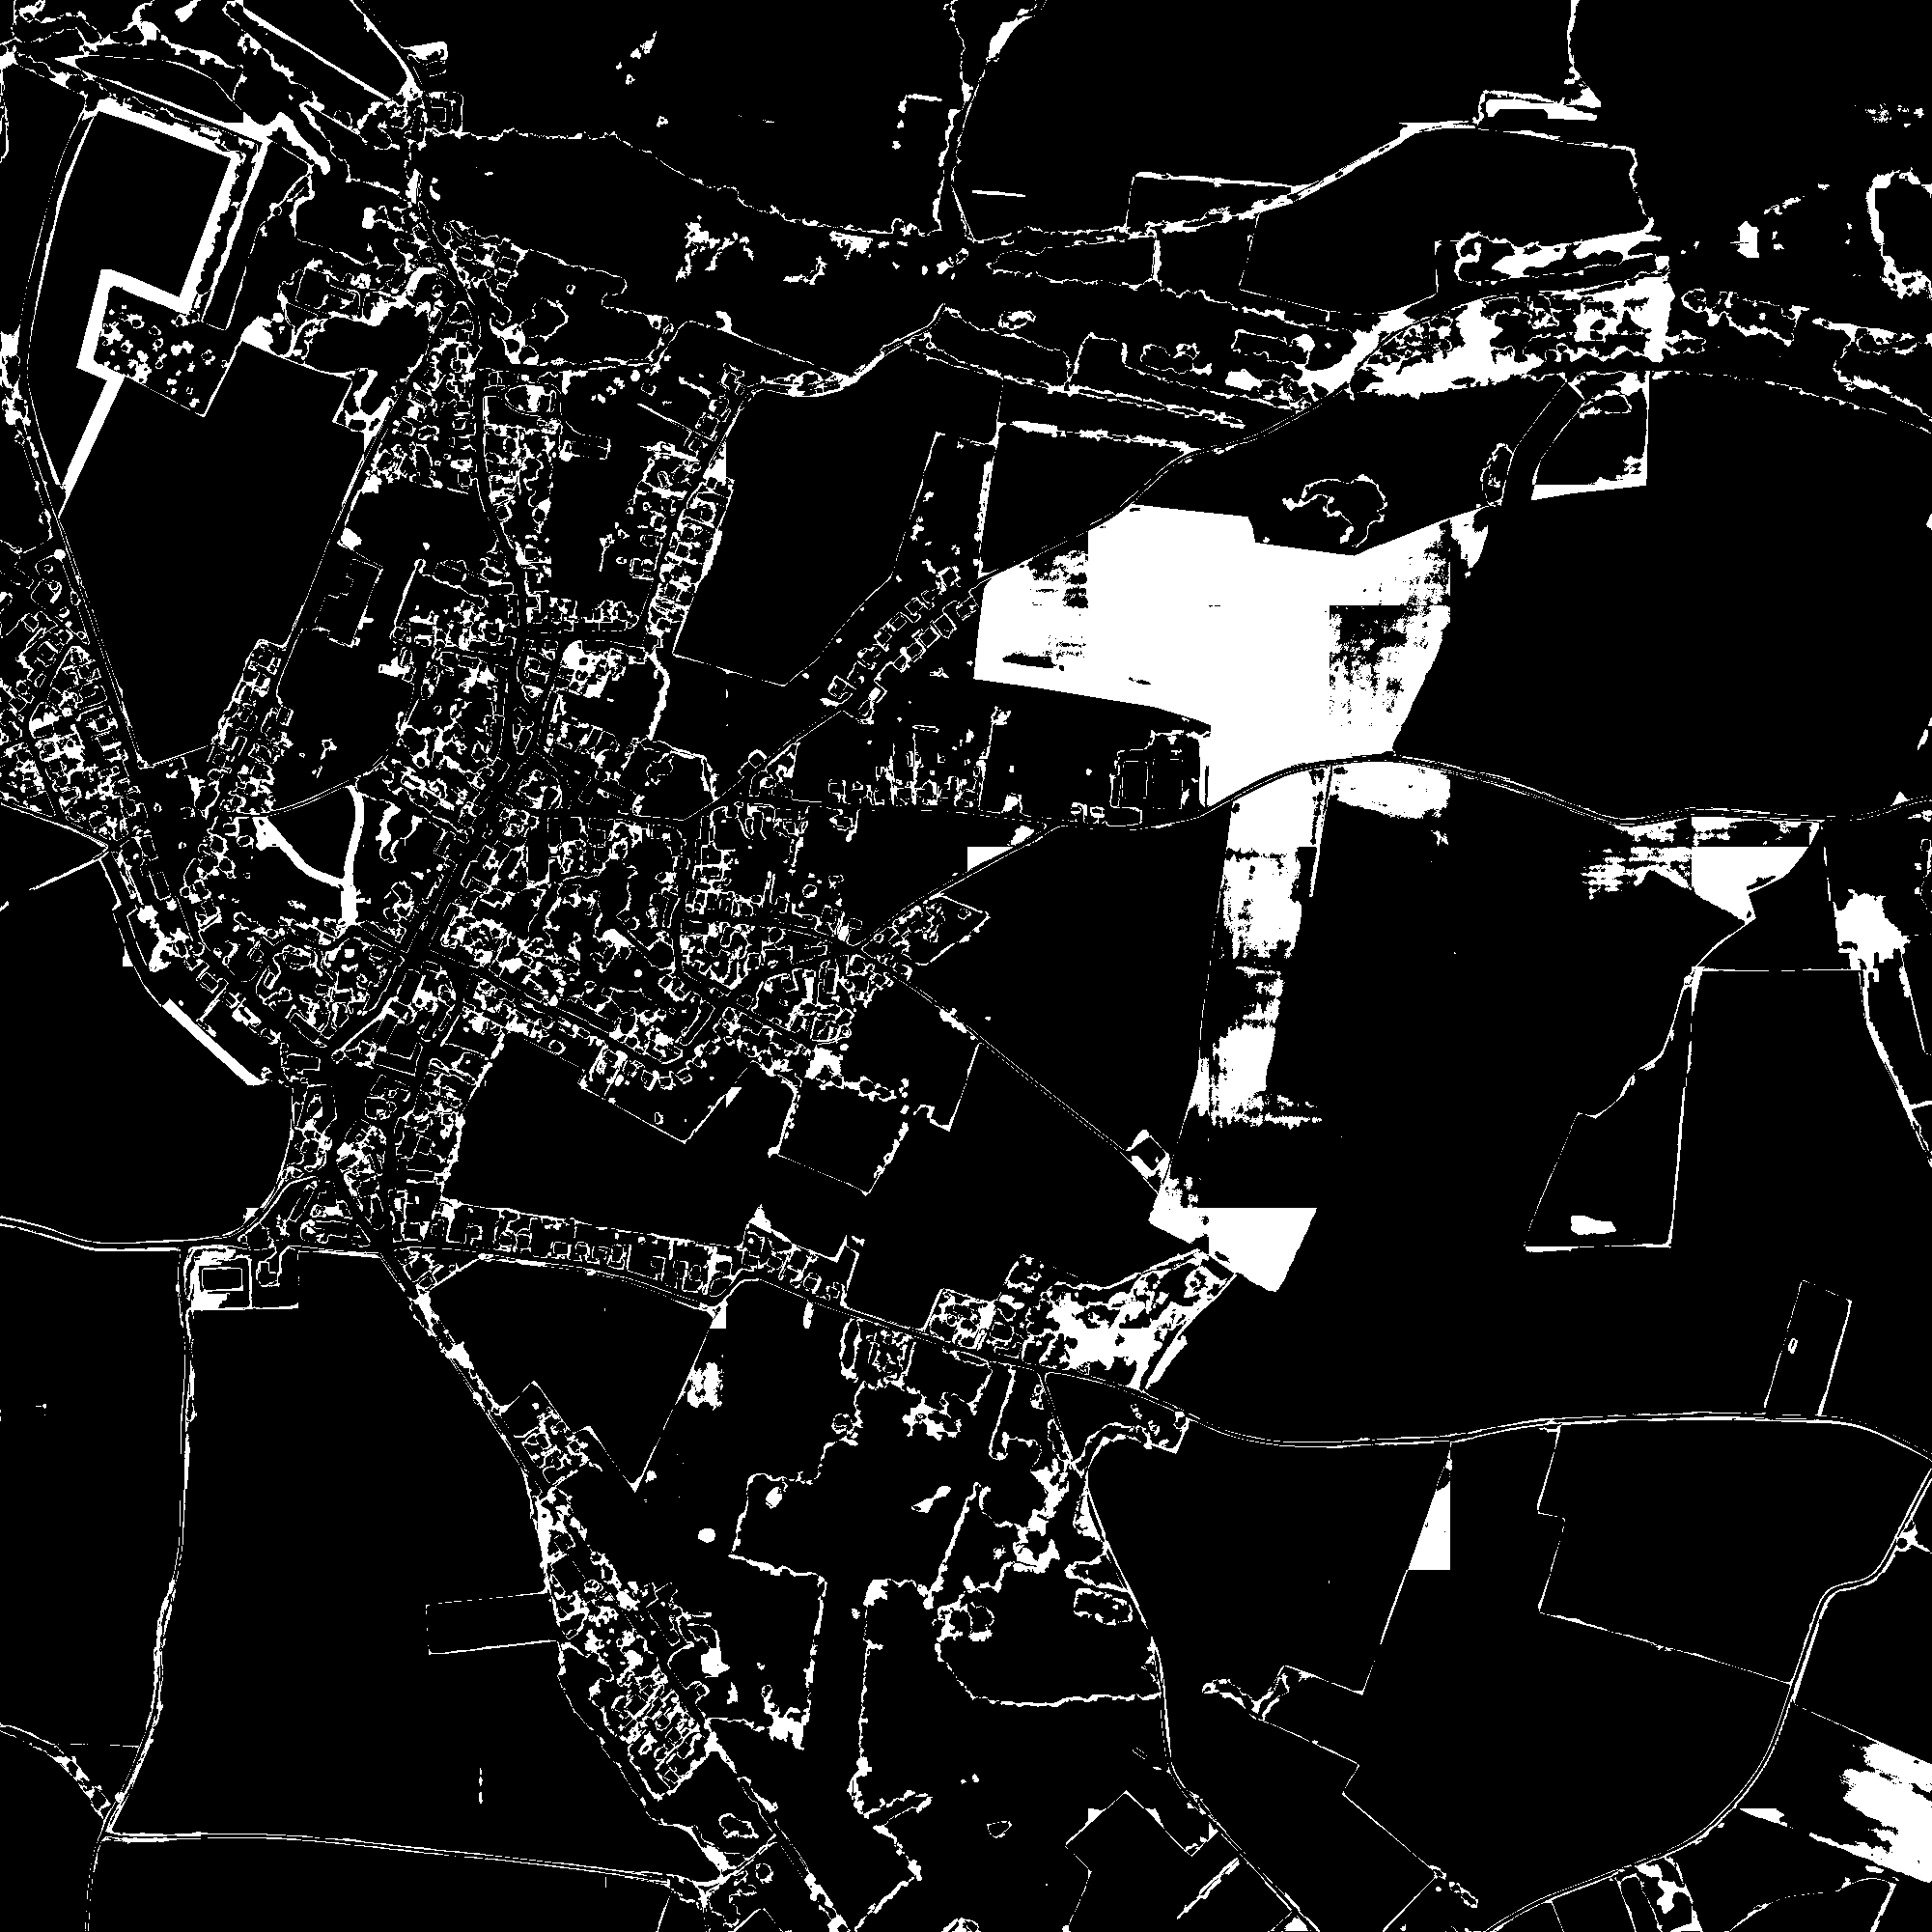

In [16]:
comparaison_mask = comparison_1bande > 0
Image.fromarray(comparaison_mask)

Comme nous le constatons, les effets de bords entrainent l'apparation de changements aux frontières de classes. Cependant, il peut être remarqué que les changements les plus importants sont bien repris.

#### Filtration de la carte des changement: erosion et dilatation

Pour adresser ces effets de bords, nous pouvons recourir à une approche naïve reposant sur des transformations morphologiques.<br>
Nous pourrions procéder à une érosion suive par une dilation via la librairie `OpenCV`: 

_Pour plus d'information sur les transformations morphologiques: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html_

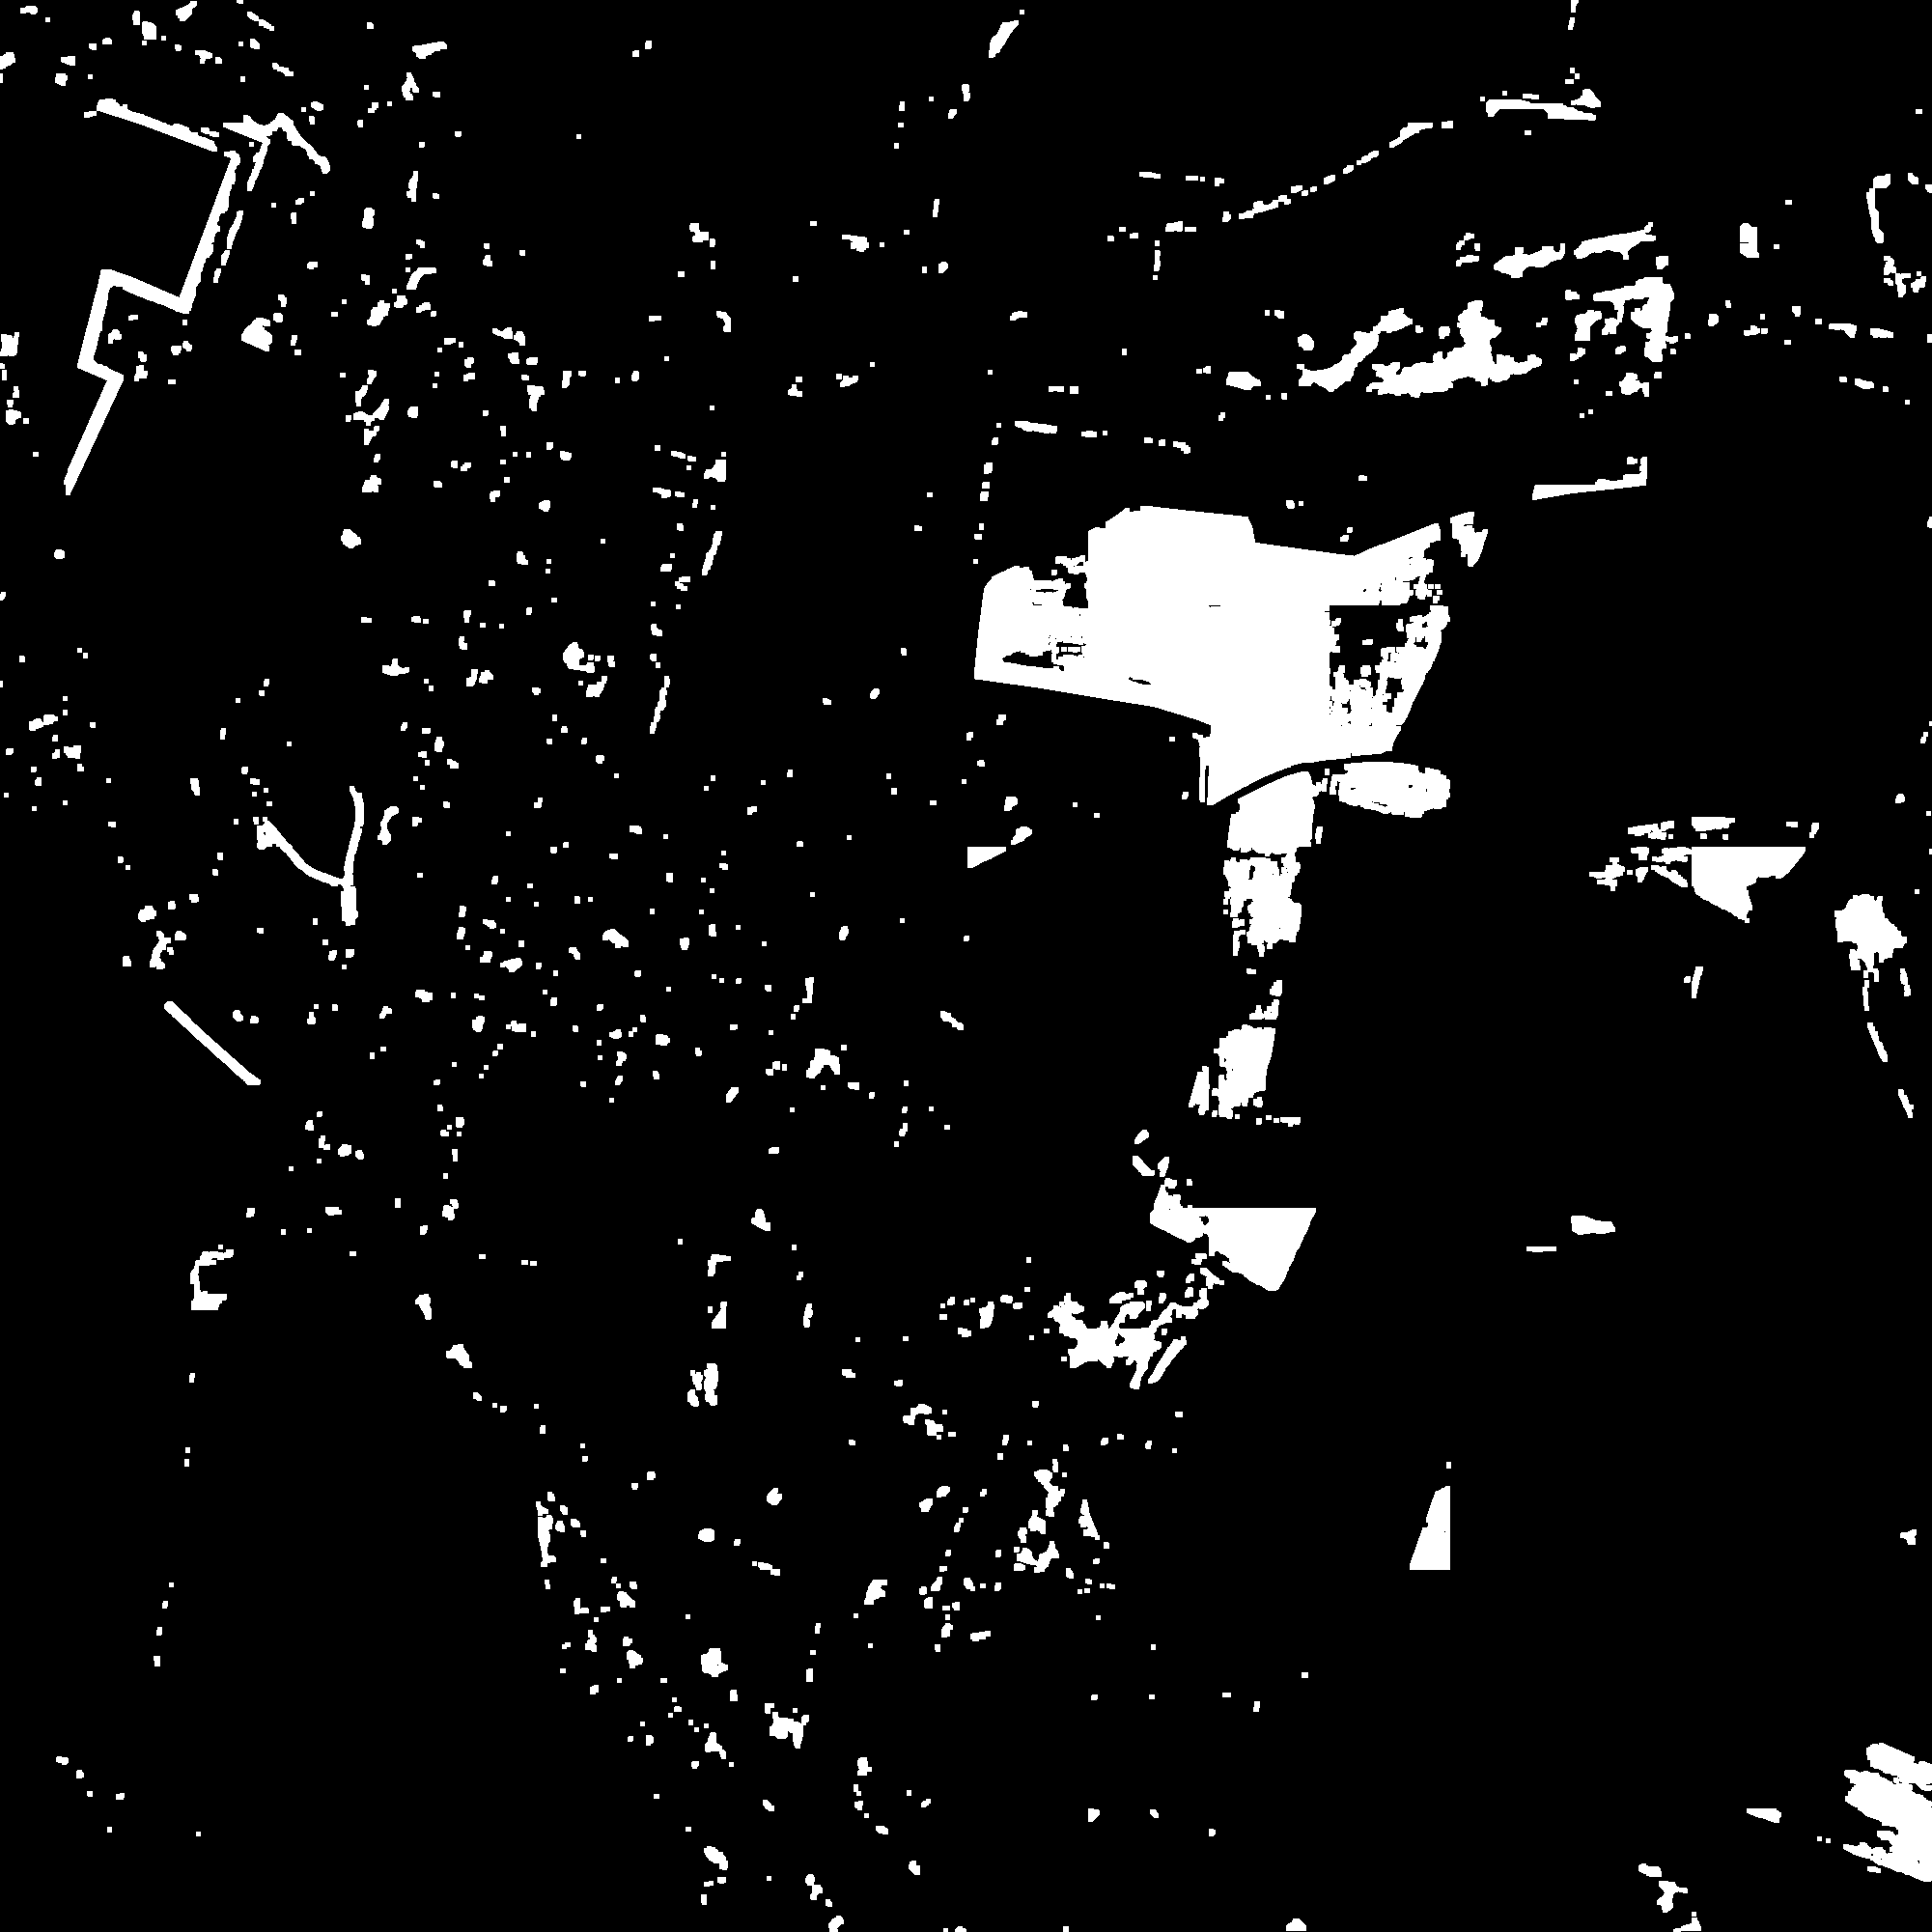

In [18]:
# Définition de la cellule à appliquer par convolution
TAILLE_KERNEL = 5  # Jouez avec la taille de la cellule/fenetre de convolution
kernel = np.ones((TAILLE_KERNEL, TAILLE_KERNEL),np.uint8)

# Erosion -> Dilation = Opening
mask_opening = cv2.morphologyEx(comparaison_mask.astype("uint8")*255, cv2.MORPH_OPEN, kernel)
Image.fromarray(mask_opening)

Cet exemple nous eclaire sur la difficulté de définir une approche simple permettant de retenir tous les changement non triviaux, tout en écartant ceux résultant d'effets de bord.

#### Visualisation des transitions d'état

Afin de visualiser les transitions d'état/label pour les changements, nous pouvons avoir recours à un diagramme __Sankey__ via la librairie `floweaver`:

_Note: cette section du _notebook_ ne fonctionne pas sur Binder_

In [19]:
labels, counts = np.unique(comparison_1bande, return_counts=True)

In [20]:
df = pd.DataFrame(
    [
        {
            "source": label//1000,
            "target": label%1000,
            "value": count,
        } for label, count in zip(labels, counts) if label != 0
    ]
)

In [21]:
lab_str_encodings = {
        1: "Revêt. art. au sol",
        2: "Const. art. hors sol",
        3: "Revêt. art. au sol",
        4: "Sols nus",
        5: "Eau",
        6: "Couv. herb. rot.",
        7: "Couv. herb. permt.",
        8: "Résineux",
        9: "Feuillus",
        80: "Résineux",
        90: "Feuillus",
    }
df["target"] = df['target'].apply(lambda x: lab_str_encodings[x])
df["source"] = df['source'].apply(lambda x: lab_str_encodings[x])

In [22]:
nodes = {
    '2018': fw.ProcessGroup(list(df['source'])),
    '2019': fw.ProcessGroup(list(df['target'])),
}

In [23]:
ordering = [['2018'], ['2019']]

In [24]:
bundles = [fw.Bundle('2018', '2019')]

In [25]:
nodes['2018'].partition = fw.Partition.Simple('source', df['source'].unique())
nodes['2019'].partition = fw.Partition.Simple('target', df['target'].unique())

In [26]:
palette = {
    "Revêt. art. au sol": "#8a8a8a",
    "Const. art. hors sol": "#dc0f0f",
    "Sols nus": "#d0d0d0",
    "Eau": "#2461f7",
    "Couv. herb. rot.": "#ffff73",
    "Couv. herb. permt.": "#e9ffbe",
    "Résineux": "#003200",
    "Feuillus": "#28c828",

}

In [27]:
sdd = fw.SankeyDefinition(nodes, bundles, ordering, flow_partition=nodes['2018'].partition)
fw.weave(sdd, df, palette=palette).to_widget(height=700, width=900)

SankeyWidget(groups=[{'id': '2018', 'type': 'process', 'title': '', 'nodes': ['2018^Revêt. art. au sol', '2018…